# Topic Analysis of SCOTUS Opinions
The overlap between judicial ideology and political inclinations of the appointed parties has been a consistent feature of the constitutional politics of the United States. This has caused an increased strain on the public’s acceptance of the distinction between what is considered to fall in the realm of law versus underlying political agendas. According to the Pew Research Center, Republican perceptions lean towards a moderate Supreme Court whereas Democrats believe it is mostly conservative in its decisions. Within this context, Justices of the Supreme Court of the United States (SCOTUS) should carefully consider the types of rhetoric they employ in their written statements. This project will aim to conduct an ideological analysis of the Justices of the Supreme Court and determine whether their political affiliations introduce a bias, if any, within their rulings over time. In doing so, we will identify if there are cyclical behaviors/patterns of conservatism or liberalism that could be associated with their political affiliation, the political era, or with evolving social movements in the country.

We use the dataset containing almost all the SCOTUS opinions ever written, which includes who they were written by, which case they were written for, which year they were filed, and whether it was a dissenting opinion. Using this data set, we will be able to track justices’ opinions over time.

## Loading Data 

In [1]:
import pandas as pd
import numpy as np

df_40 = pd.read_csv("Data/all_opinions_1940.csv")
df_40['date_filed'] = df_40['date_filed'].apply(pd.to_datetime, errors='coerce')
df_40['author_lastname'] = df_40.author_name.apply(lambda x: x.split(" ")[-1]) #get last name of each justice
df_40['author_lastname'] = np.where((df_40['author_lastname'] == 'Roberts') & (df_40['year_filed']<2005), 'Roberts, O.', df_40['author_lastname'])
df_40 = df_40[df_40['per_curiam']==False] # per curiam opinions are opinions the court deemed to be so straightforward there is no named author
df_40 = df_40.drop(columns=['Unnamed: 0','federal_cite_one','absolute_url','cluster','per_curiam'])

print(df_40.shape)
print(df_40.dtypes)
df_40.head(3)

(14924, 11)
author_name                        object
category                           object
case_name                          object
date_filed                 datetime64[ns]
year_filed                          int64
scdb_id                            object
scdb_decision_direction           float64
scdb_votes_majority               float64
scdb_votes_minority               float64
text                               object
author_lastname                    object
dtype: object


,author_name,category,case_name,date_filed,year_filed,scdb_id,scdb_decision_direction,scdb_votes_majority,scdb_votes_minority,text,author_lastname
0,Justice Roberts,majority,McCutcheon v. Federal Election Comm'n,2014-04-02,2014,2013-033,1.0,5.0,4.0,There is no right more basic in our democracy ...,Roberts
1,Justice Thomas,concurring,McCutcheon v. Federal Election Comm'n,2014-04-02,2014,2013-033,1.0,5.0,4.0,I adhere to the view that this Court’s decisio...,Thomas
2,Justice Breyer,dissenting,McCutcheon v. Federal Election Comm'n,2014-04-02,2014,2013-033,1.0,5.0,4.0,"Nearly 40 years ago in Buckley v. Valeo, 424 U...",Breyer


In [2]:
from datetime import datetime
df_justice = pd.read_csv("./Data/JusticeData.csv")
df_justice = df_justice.drop(columns=['StateApptFrom'])
df_justice['JusticeLastName'] = df_justice.Name.apply(lambda x: x.split(",")[0]) #get last name of each justice
df_justice[['DateServiceTerminated','JudicialOathTaken']] = df_justice[['DateServiceTerminated','JudicialOathTaken']].apply(pd.to_datetime, errors='coerce')
df_justice['JusticeLastName'] = np.where((df_justice['JusticeLastName'] == 'Roberts') & (df_justice['DateServiceTerminated']<datetime.strptime('January 1, 2005', '%B %d, %Y')), 'Roberts, O.', df_justice['JusticeLastName'])
df_justice = df_justice[(df_justice['DateServiceTerminated'] >= datetime.strptime('January 1, 1940', '%B %d, %Y')) | (df_justice['DateServiceTerminated'].isna()==True)]
df_justice = df_justice.drop_duplicates(subset='Name', keep='first')
df_justice.fillna({'ChiefJustice': 0}, inplace=True)

print(df_justice.shape)
print(df_justice.dtypes)

(44, 6)
ChiefJustice                    float64
Name                             object
AppointedByPresident             object
JudicialOathTaken        datetime64[ns]
DateServiceTerminated    datetime64[ns]
JusticeLastName                  object
dtype: object


In [3]:
df_presidents = pd.read_csv("./Data/PresidentialParty.csv",usecols=['PRESIDENT','POLITICAL PARTY'])
print(df_presidents.shape)
print(df_presidents.dtypes)

df_presidents['LastName'] = df_presidents['PRESIDENT'].apply(lambda x: x.split(" ")[-1]) #get last name of each pres
df_presidents.loc[41, 'LastName'] = 'Bush, G. W.' #deal with weird cases of same last name 
df_presidents.loc[39, 'LastName'] = 'Bush, G. H. W.' 
df_presidents.loc[34, 'LastName'] = 'Johnson, L.'
df_presidents.loc[30, 'LastName'] = 'Roosevelt, F.'
df_presidents.loc[24, 'LastName'] = 'Roosevelt, T.'
df_presidents.loc[8, 'LastName'] = 'Harrison, W. H.'  
df_presidents.loc[5, 'LastName'] = 'Adams, J. Q.'
df_presidents.loc[1, 'LastName'] = 'Adams, J.'  

(45, 2)
PRESIDENT          object
POLITICAL PARTY    object
dtype: object


In [4]:
df_justice.AppointedByPresident = df_justice.AppointedByPresident.astype(str)
df_presidents.LastName = df_presidents.LastName.astype(str)
df_justice = df_justice.merge(df_presidents, left_on='AppointedByPresident', right_on='LastName', how='left').drop(columns=['PRESIDENT','LastName'])
df_40 = df_40.merge(df_justice, left_on='author_lastname', right_on='JusticeLastName', how="left").drop(columns=['author_lastname','JusticeLastName','Name'])

In [5]:
df_40[df_40['POLITICAL PARTY'].isna() == True] #Let's drop these
df_40 = df_40.dropna(subset = 'POLITICAL PARTY')

In [6]:
#Text field is the opinion
#important: Authorname, case_name, category, date_filed,

In [7]:
# df_40 = df_40[df_40['author_name'] != 'Justice Or']
# df_40 = df_40[df_40['author_name'] != 'Justice And']
# df_40 = df_40[df_40['author_name'] != 'Justice O2122']

## Transforming Data

We are going to create lists of the authors of every case and their political affiliation. This is done to perform easier analyses of with the data and differentiating between Democratic and Republican Affilitations.

In [8]:
authors = df_40['author_name']
category = df_40['category']
case_name = df_40['case_name']
year = df_40['year_filed']
political_aff = df_40['POLITICAL PARTY']
case_txt = df_40['text']
case_id = df_40['scdb_id']

The following stop words were incorporated to avoid vocabulary that could be repeatitive among both political affiliationns. They are substracted from the datasets.

In [9]:
import re

stop_words = ['..','__','___','___','_','-','--','there','.',';',':','the','to','in','rt','of','a', 'for','and','is','on','amp','you','i','at','will','our','we','be','with','that','it','this','are','https','s','have','by','from','has','all','as','not','was','out','t','your','my','who','her','me','he','about','so','make','just''2','w','she','they','us','his','if','up','again','an','what','one','no','here','but','can','last','than','were','do','would','been','am','http','had','when','made','them','or','there','another','isil','aumf','youre']
w_txt = [sentence.lower().split() for sentence in case_txt] #CHANGE AT THE END!!!

words_txt = [[word for word in k if word not in stop_words 
            and re.match('[a-zA-Z]+$', word)] for k in w_txt]

## Counting Frequencies
The following are the frequencies of the most used words in the historical sentences given by the Supreme Court. These ones include both political parties.

In [10]:
words = [word for sentence in words_txt for word in sentence]

from collections import Counter

freq = Counter(words)
f = sorted([(freq[k],k) for k in freq], reverse = True)

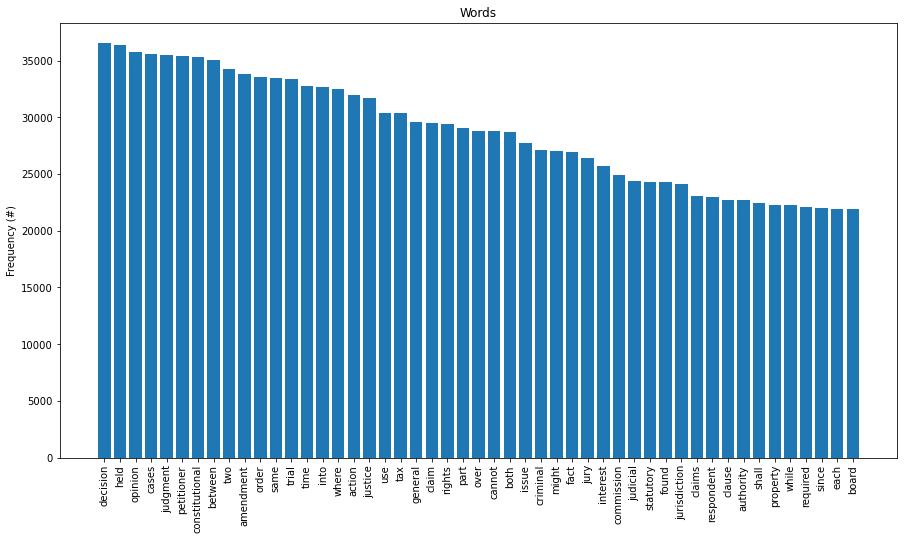

In [11]:
import matplotlib.pyplot as plt

fr = f[51:100]
w_w = [k for v,k in fr]
f_w = [v for v,k in fr]
plt.figure(figsize=(15, 8))
plt.bar(w_w,f_w)
plt.ylabel("Frequency (#)")
plt.title("Words")
plt.xticks(rotation=90)
plt.show()

## Frequency of Words by Political Affiliation
The following frequencies show the top words used based on the political affiliation of the judges.

In [12]:
df_R_40 = df_40[df_40['POLITICAL PARTY'] == 'Republican']
df_D_40 = df_40[df_40['POLITICAL PARTY'] == 'Democratic']

In [13]:
l = range(len(political_aff))

## DEMOCRATS
w_txt = [sentence.lower().split() for sentence in df_D_40['text']]
words_txt_D = [[word for word in k if word not in stop_words 
            and re.match('[a-zA-Z]+$', word)] for k in w_txt]
words_D = [word for sentence in words_txt_D for word in sentence]
freq_D = Counter(words_D)
f_D = sorted([(freq_D[k],k) for k in freq_D], reverse = True)
w_w_D = [k for v,k in f_D]
f_w_D = [v for v,k in f_D]

## REPUBLICANS
w_txt = [sentence.lower().split() for sentence in df_R_40['text']]
words_txt_R = [[word for word in k if word not in stop_words 
            and re.match('[a-zA-Z]+$', word)] for k in w_txt]

words_R = [word for sentence in words_txt_R for word in sentence]
freq_R = Counter(words_R)
f_R = sorted([(freq_R[k],k) for k in freq_R], reverse = True)
w_w_R = [k for v,k in f_R]
f_w_R = [v for v,k in f_R]

## Top Words for Both Democrats and Republicans
The following graph includes both 50 top words for the sentences given by Democratic and Republican judges.

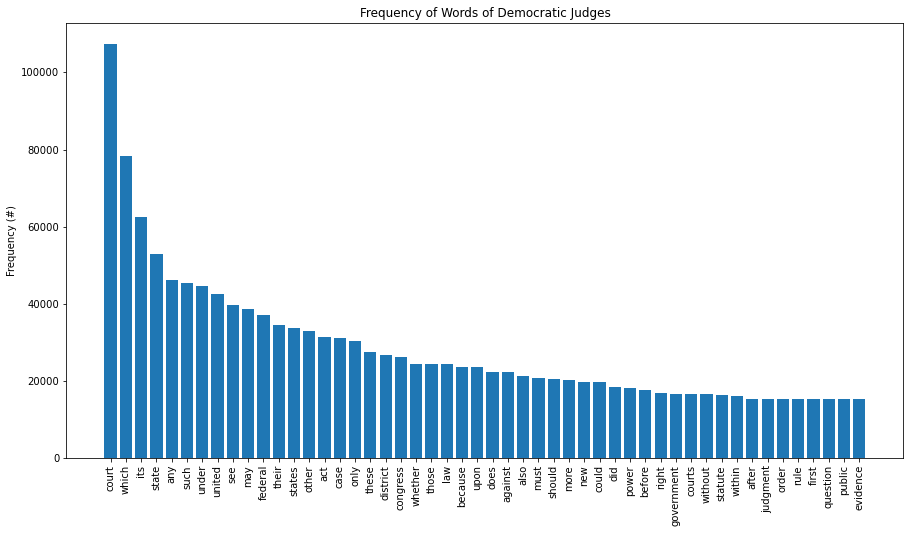

In [14]:
plt.figure(figsize=(15, 8))
plt.bar(w_w_D[:50],f_w_D[:50])
plt.title("Frequency of Words of Democratic Judges")
plt.ylabel("Frequency (#)")
plt.xticks(rotation=90)
plt.show()

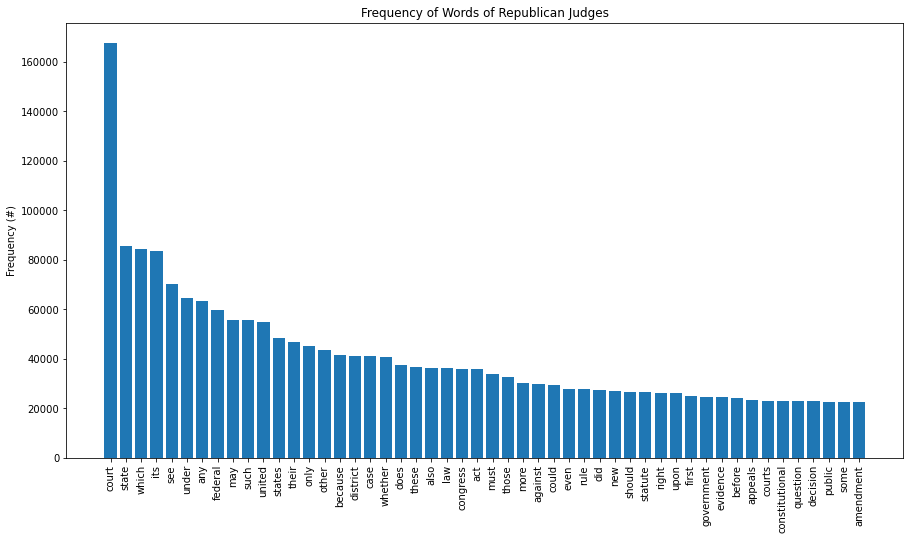

In [15]:
plt.figure(figsize=(15, 8))
plt.bar(w_w_R[:50],f_w_R[:50])
plt.title("Frequency of Words of Republican Judges")
plt.ylabel("Frequency (#)")
plt.xticks(rotation=90)
plt.show()

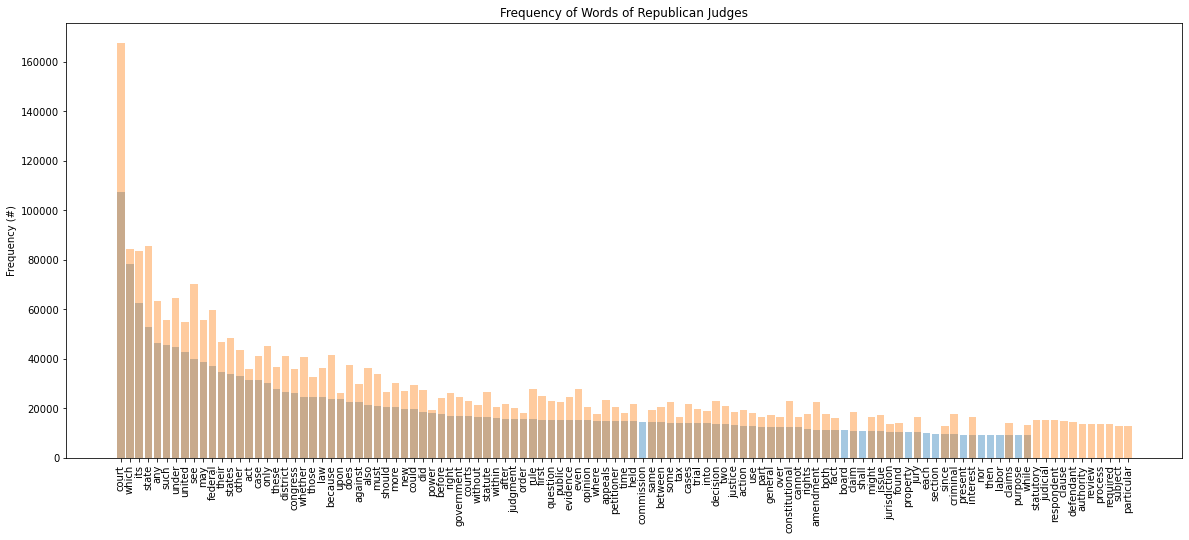

In [16]:
plt.figure(figsize=(20, 8))
plt.bar(w_w_D[:100],f_w_D[:100], alpha=0.4)
plt.bar(w_w_R[:100],f_w_R[:100], alpha=0.4)
plt.title("Frequency of Words of Republican Judges")
plt.ylabel("Frequency (#)")
plt.xticks(rotation=90)
plt.show()

## PMI

Our next step is to perform a PMI analys among every word related to sentences given by each, Democratic, and Republican judges. We chose PMI to measure association of different words and calculate the probability of each word P(word) by considering unique words (non-repeated) per sentence over the number of sentences. The probability of Democratic P(Democratic) or Republican P(Republican) is calculated by the number of sentences associated to a Republican or Democratic judge among the total number of sentences. The probability of a word coming from a Democratic P(word|Democratic) or Republican P(word|Republican) judge is calculated based on if the word appears in a sentence that is from a Democratic or Republican judge.

In [17]:
import math

only_words_txt_D = [list(set(only_words)) for only_words in words_txt_D] #unique words per sentence
only_words_txt_R = [list(set(only_words)) for only_words in words_txt_R] #unique words per sentence

words_one_per_sentence = [word for sentence in only_words_txt_R for word in sentence] + [word for sentence in only_words_txt_D for word in sentence]
count_words = Counter(words_one_per_sentence)
total_words = len(words_one_per_sentence)

no_sentences = len(only_words_txt_R) + len(only_words_txt_D)

count_words = Counter(words_one_per_sentence)

count_democratic_words = Counter()
count_Republican_words = Counter()

#Probability word and Democratic
for sentence in only_words_txt_D:
    for word in sentence:
        count_democratic_words[word] += 1

for sentence in only_words_txt_R:
    for word in sentence:
        count_Republican_words[word] += 1

prob_words = {word : (count_words[word]/no_sentences) for word in count_words}
            
prob_democratic_words = {word : (count_democratic_words[word]/no_sentences) for word in count_democratic_words}
prob_Republican_words = {word : (count_Republican_words[word]/no_sentences) for word in count_Republican_words}

prob_democratic_sentences = sum([1 for i in political_aff if i == 'Democratic'])/no_sentences
prob_republican_sentences = sum([1 for i in political_aff if i == 'Republican'])/no_sentences

The following are the 50 top PMIs of words that appear more than 10 times in any sentence promoted by a Democratic or Republican judge. The idea is to have a sence of words that are more likely to be associated to a Republican or Democratic judge.

In [18]:
#PMI for every word and Democrats
PMI_Words_and_Democrats = sorted([(math.log(prob_democratic_words[word]/(prob_words[word]*prob_democratic_sentences)), word) 
                                  for word in prob_words 
                                  if word in prob_democratic_words and count_democratic_words[word] > 10], reverse = True)

#PMI for every word and Republicans
PMI_Words_and_Republicans = sorted([(math.log(prob_Republican_words[word]/(prob_words[word]*prob_republican_sentences)), word) 
                                    for word in prob_words 
                                    if word in prob_Republican_words and count_Republican_words[word] > 10], reverse = True)


print("\nWords with largest PMI's for Democrats:")
for i in range(50):
    print(str(i+1) + '.', PMI_Words_and_Democrats[i][1] + ':', PMI_Words_and_Democrats[i][0])
    
print("\nWords with largest PMI's for Republicans:")
for i in range(50):
    print(str(i+1) + '.', PMI_Words_and_Republicans[i][1] + ':', PMI_Words_and_Republicans[i][0])


Words with largest PMI's for Democrats:
1. honeyman: 0.8341099777659319
2. carloads: 0.8341099777659319
3. harrow: 0.8341099777659318
4. embracive: 0.8341099777659318
5. derstand: 0.8341099777659318
6. perchance: 0.7769515639259834
7. permeating: 0.7695714566283608
8. overhanging: 0.7695714566283608
9. escalator: 0.7695714566283608
10. tomkins: 0.7651171062789803
11. senn: 0.7651171062789803
12. recurringly: 0.7651171062789803
13. ecker: 0.7651171062789803
14. broderick: 0.7651171062789803
15. pathmarking: 0.7634924105519784
16. minton: 0.7617893161863057
17. treinies: 0.76000200561221
18. raft: 0.76000200561221
19. prophetic: 0.76000200561221
20. vitamin: 0.7540672700923954
21. sterilize: 0.7540672700923954
22. revest: 0.7540672700923954
23. choses: 0.7540672700923954
24. assail: 0.7507283688268808
25. streetcar: 0.747098600776302
26. saturation: 0.747098600776302
27. kaw: 0.747098600776302
28. fauntleroy: 0.747098600776302
29. angle: 0.7340265192089493
30. tin: 0.7228843426557074
31

## Latent Dirichlet Allocation (LDA)

We run a topic modeling analysis to understand and discover hidden themes in the collection and further classifying the documents into the discovered themes using word clouds.  

We use LDA technique within topic modeling to vectorize and create stopwords to further restrict the dataset by assessing words that are more frequent or infrequent. Once the topics have been separated, they can be evaluated overtime to see if they are becoming more common. This will help us understand common themes (topics) prominent in each judge's opinions which can strongly reflect issues that matter to each party (republican or democrat affiliation highlighted in graphs below) 


In [20]:
vocab_size = 1000
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer does tokenization and can remove terms that occur too frequently, not frequently enough, or that are stop words

# document frequency (df) means number of documents a word appears in
df_R_40 = df_R_40[df_R_40['category'] == 'majority']
df_D_40 = df_D_40[df_D_40['category'] == 'majority']

tf_vectorize_R = CountVectorizer(max_df = 0.5, #discuss max_df, min_df 
                                min_df = 1,
                                stop_words ='english',
                                max_features = vocab_size)

tf_vectorize_D = CountVectorizer(max_df = 0.5, #discuss max_df, min_df 
                                min_df = 1,
                                stop_words ='english',
                                max_features = vocab_size)

tf_R = tf_vectorize_R.fit_transform(df_R_40["text"]) #read text column only for republicans
tf_D = tf_vectorize_D.fit_transform(df_D_40["text"]) #read text column only for democrats


We now fit an LDA model to the data

In [21]:
num_topics = 10 #discuss num_topics- how to pick this number 

from sklearn.decomposition import LatentDirichletAllocation
lda_R = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda_D = LatentDirichletAllocation(n_components=num_topics, random_state=0)

lda_R.fit(tf_R)
lda_D.fit(tf_D)

LatentDirichletAllocation(random_state=0)

In [22]:
topic_word_distributions_R = np.array([row / row.sum() for row in lda_R.components_])
topic_word_distributions_D = np.array([row / row.sum() for row in lda_D.components_])

In [23]:
num_top_words = 10 

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names()
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()

    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':',
                  topic_word_distributions[topic_idx, word_idx])
        print()

print_top_words(topic_word_distributions_R, num_top_words, tf_vectorize_R)

Displaying the top 10 words per topic and their probabilities within the topic...

[Topic 0]
counsel : 0.025600066103126658
defendant : 0.016784992859245895
habeas : 0.013315649447496478
hearing : 0.011831924783922329
testimony : 0.011624309862784855
criminal : 0.01085347998109755
defense : 0.009500267041005369
petition : 0.008745846732209267
attorney : 0.008662853318706962
motion : 0.00803735078015542

[Topic 1]
criminal : 0.018718522604225466
police : 0.015754423723035912
search : 0.01511561704952097
officers : 0.013381214160937113
officer : 0.012363691150084836
offense : 0.011635332255724651
fourth : 0.011134983644939998
crime : 0.01029506332051824
arrest : 0.00945096178189724
warrant : 0.009346905330107562

[Topic 2]
speech : 0.01114661538394716
city : 0.010244860909840755
political : 0.009001161394523541
constitution : 0.008596952524225421
protection : 0.008470940717911874
clause : 0.008073758582128138
religious : 0.007577659858815436
county : 0.007513347097548085
patent : 0.00635

C:\Users\ktnha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [24]:
print_top_words(topic_word_distributions_D, num_top_words, tf_vectorize_D)

Displaying the top 10 words per topic and their probabilities within the topic...

[Topic 0]
trial : 0.029293510695600378
jury : 0.023036782993825312
defendant : 0.01514963322696731
criminal : 0.01397657384921712
judge : 0.012834315300472496
counsel : 0.01080454277250348
amendment : 0.009675169980788836
conviction : 0.009158759655685732
crime : 0.008584320709694164
sentence : 0.008505034407208192

[Topic 1]
board : 0.04236370914802067
union : 0.03263011389251103
employees : 0.032009760052163425
labor : 0.03105817080448867
employer : 0.01976156981137471
employee : 0.015486043388272844
work : 0.013966281450396271
bargaining : 0.012716169407278212
contract : 0.012543719185381831
employment : 0.011437284141813971

[Topic 2]
commission : 0.0719721682548518
commerce : 0.029924092930138077
interstate : 0.027632098397172542
rate : 0.014921116479072764
rates : 0.014211863695673843
service : 0.014116483171806821
gas : 0.013546215824348383
carrier : 0.01318186862904093
transportation : 0.01177970

In [25]:
#pip install https://github.com/sulunemre/word_cloud/releases/download/2/wordcloud-0.post1+gd8241b5-cp39-cp39-win_amd64.whl

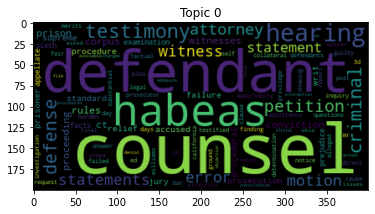

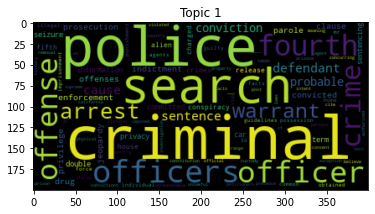

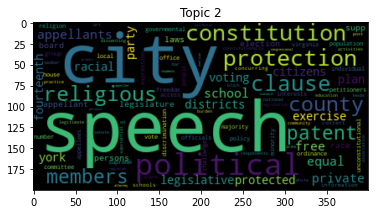

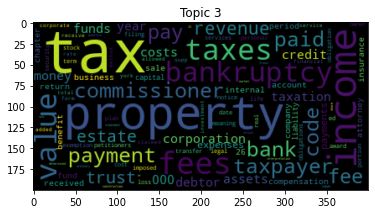

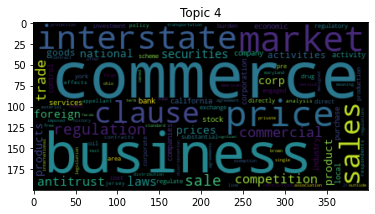

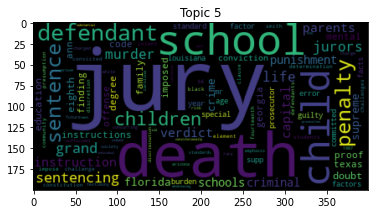

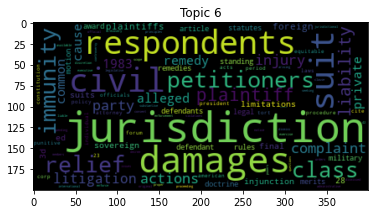

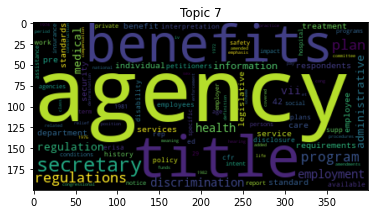

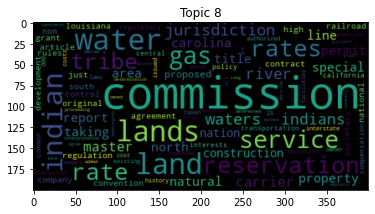

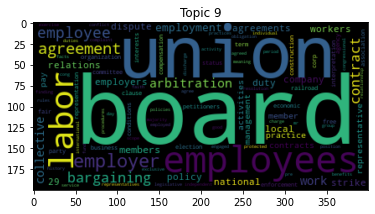

In [26]:
from wordcloud import WordCloud

num_max_word_cloud_words = 100

vocab = tf_vectorize_R.get_feature_names()
num_topics = len(topic_word_distributions_R)

for topic_idx in range(num_topics):
    wc = WordCloud(max_words=num_max_word_cloud_words)
    wc.generate_from_frequencies(dict(zip(vocab, topic_word_distributions_R[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Topic %d' % topic_idx)

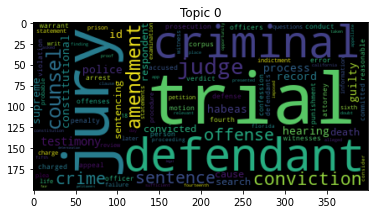

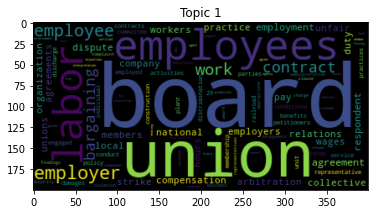

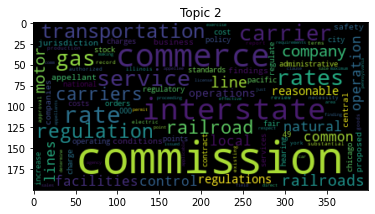

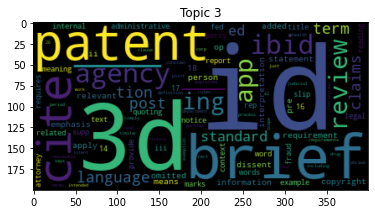

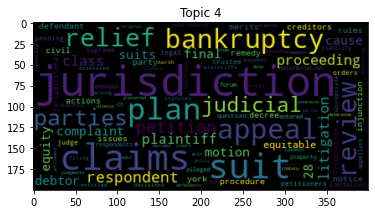

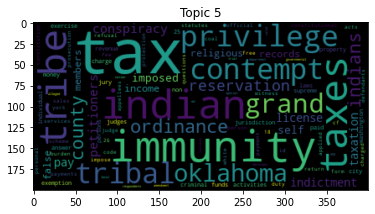

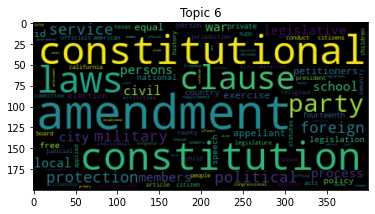

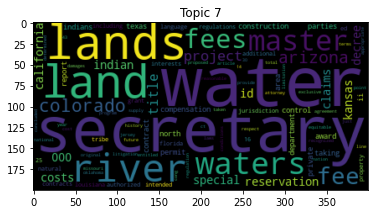

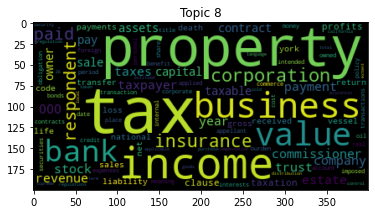

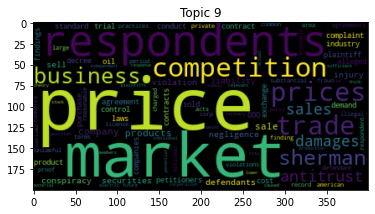

In [27]:
from wordcloud import WordCloud

num_max_word_cloud_words = 100

vocab = tf_vectorize_D.get_feature_names()
num_topics = len(topic_word_distributions_R)

for topic_idx in range(num_topics):
    wc = WordCloud(max_words=num_max_word_cloud_words)
    wc.generate_from_frequencies(dict(zip(vocab, topic_word_distributions_D[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Topic %d' % topic_idx)

#### Topic 9 - employer and labour
#### Topic 5 - school board, education
#### Topic 7 - Gerrymandering?
#### Topic 0 - death penalty?

In [29]:
tf_vectorizer = CountVectorizer(max_df = 0.5, #discuss max_df, min_df 
                                min_df = 1,
                                stop_words ='english',
                                max_features = vocab_size)


tf = tf_vectorizer.fit_transform(df_40["text"]) #read text column only 
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(tf)

doc_topic_matrix = lda.transform(tf)

lsa_300_df = pd.concat(
    [
        df_40[['author_name','year_filed','case_name', 'category']].reset_index(drop=True), 
        pd.DataFrame(doc_topic_matrix)
    ],
    axis=1)

lsa_300_df.head()

,author_name,year_filed,case_name,category,0,1,2,3,4,5,6,7,8,9
0,Justice Roberts,2014,McCutcheon v. Federal Election Comm'n,majority,0.241168,0.047250,0.010905,0.029064,0.000042,0.422564,0.000042,0.000042,0.241372,0.007550
1,Justice Thomas,2014,McCutcheon v. Federal Election Comm'n,concurring,0.500062,0.000338,0.000338,0.000338,0.000338,0.179375,0.000338,0.000338,0.318197,0.000338
2,Justice Breyer,2014,McCutcheon v. Federal Election Comm'n,dissenting,0.343650,0.050345,0.000052,0.063394,0.000052,0.349489,0.000052,0.000052,0.192863,0.000052
3,Justice Kagan,2014,Kaley v. United States,majority,0.291114,0.085595,0.000060,0.007939,0.167652,0.000060,0.000060,0.447400,0.000060,0.000060
4,Justice Roberts,2014,Kaley v. United States,dissenting,0.189359,0.100565,0.000075,0.005427,0.248294,0.000075,0.000075,0.453673,0.000075,0.002381


In [30]:
lda_df = pd.concat(
    [
        df_40[['author_name','year_filed','case_name', 'category']].reset_index(drop=True), 
        pd.DataFrame(doc_topic_matrix)
    ],
    axis=1)

lda_by_year = lda_df[['year_filed'] + list(range(num_topics))].groupby('year_filed').agg('mean')
lda_by_year.head()

,0,1,2,3,4,5,6,7,8,9
year_filed,,,,,,,,,,
1940,0.013403,0.336020,0.046996,0.025304,0.136760,0.077228,0.168236,0.041559,0.045904,0.108589
1941,0.010289,0.318903,0.056463,0.031714,0.130044,0.085961,0.168419,0.064551,0.049374,0.084282
1942,0.033540,0.248588,0.043871,0.028746,0.111999,0.079899,0.208714,0.087180,0.048247,0.109217
1943,0.019199,0.234043,0.076562,0.038696,0.108313,0.077034,0.186602,0.105672,0.052113,0.101765
1944,0.021003,0.227114,0.049055,0.032149,0.109039,0.093539,0.220625,0.077490,0.040548,0.129439


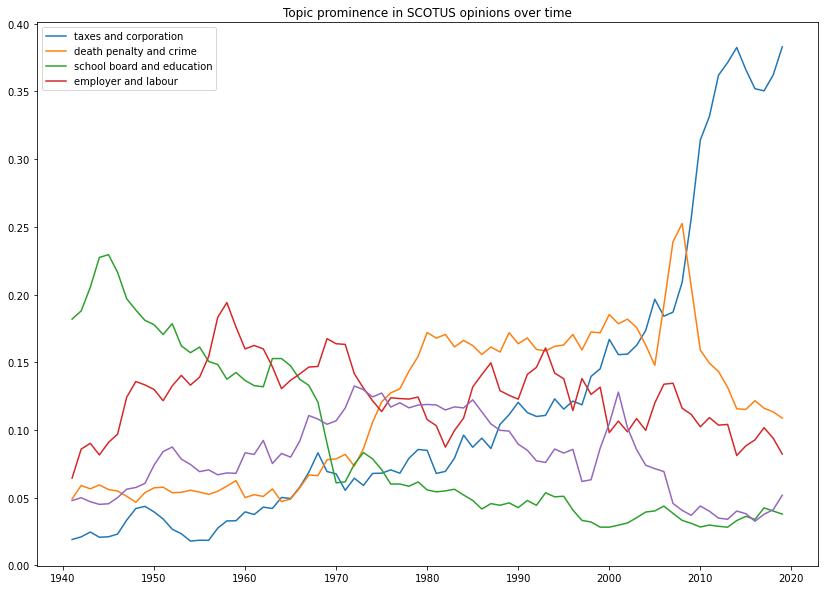

In [31]:
x = lda_by_year.index[1:-1]
plt.figure(figsize=(14,10))

for feature in [1,3,7,8,9]:
    y_vals = list(lda_by_year[feature-1])
    y = [(y_vals[j] + y_vals[j-1] + y_vals[j+1])/3 for j in range(1, len(y_vals)-1)] # rolling mean for smoothing
    plt.plot(x,y)
plt.legend(labels=[
    'taxes and corporation',
    'death penalty and crime',
    'school board and education',
    'employer and labour'
])  
plt.title("Topic prominence in SCOTUS opinions over time")
plt.show()

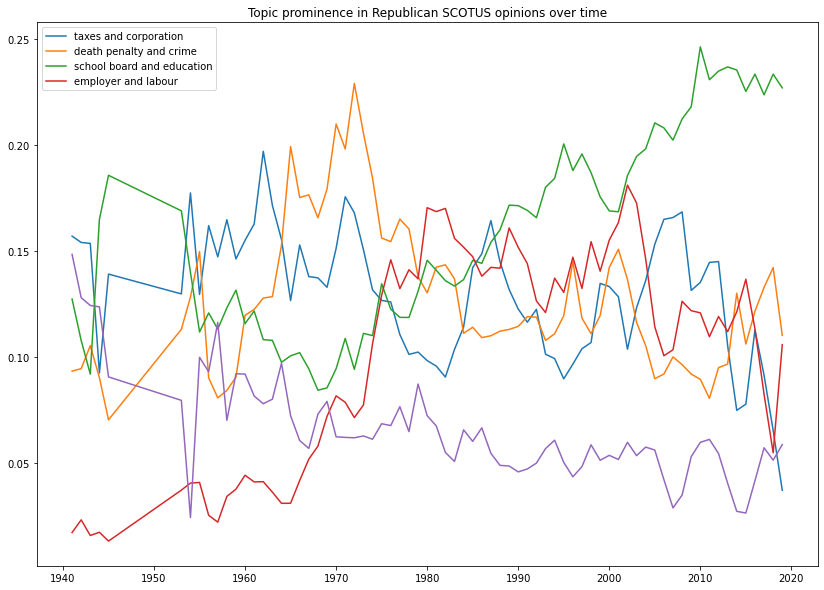

In [32]:
doc_topic_matrix = lda_R.transform(tf_R)

lda_R_df = pd.concat(
    [
        df_R_40[['author_name','year_filed','case_name', 'category']].reset_index(drop=True), 
        pd.DataFrame(doc_topic_matrix)
    ],
    axis=1)

lda_by_year = lda_R_df[['year_filed'] + list(range(num_topics))].groupby('year_filed').agg('mean')
lda_by_year.head()

x = lda_by_year.index[1:-1]
plt.figure(figsize=(14,10))

for feature in [1,3,7,8,9]:
    y_vals = list(lda_by_year[feature-1])
    y = [(y_vals[j] + y_vals[j-1] + y_vals[j+1])/3 for j in range(1, len(y_vals)-1)] # rolling mean for smoothing
    plt.plot(x,y)
plt.legend(labels=[
    'taxes and corporation',
    'death penalty and crime',
    'school board and education',
    'employer and labour'
])  
plt.title("Topic prominence in Republican SCOTUS opinions over time")
plt.show()

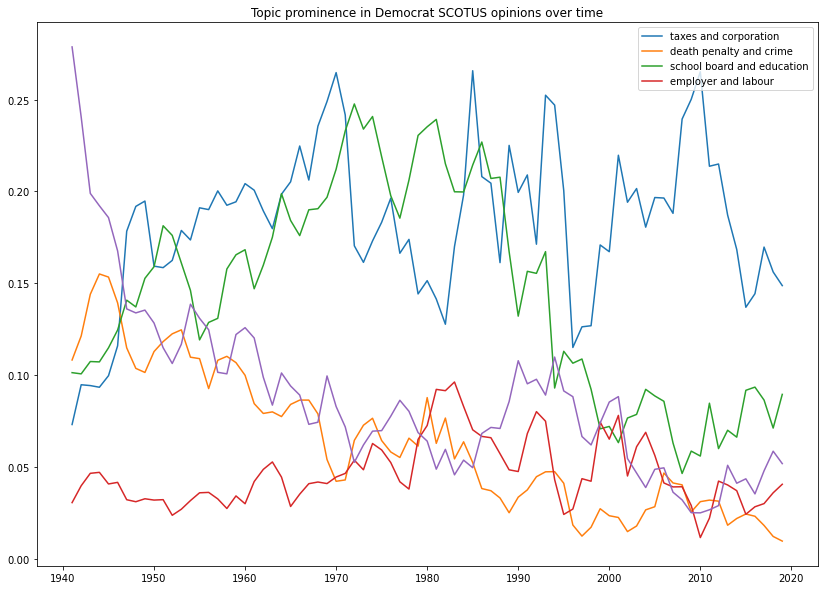

In [33]:
doc_topic_matrix = lda_D.transform(tf_D)

lda_D_df = pd.concat(
    [
        df_D_40[['author_name','year_filed','case_name', 'category']].reset_index(drop=True), 
        pd.DataFrame(doc_topic_matrix)
    ],
    axis=1)

lda_by_year = lda_D_df[['year_filed'] + list(range(num_topics))].groupby('year_filed').agg('mean')
lda_by_year.head()

x = lda_by_year.index[1:-1]
plt.figure(figsize=(14,10))

for feature in [1,3,7,8,9]:
    y_vals = list(lda_by_year[feature-1])
    y = [(y_vals[j] + y_vals[j-1] + y_vals[j+1])/3 for j in range(1, len(y_vals)-1)] # rolling mean for smoothing
    plt.plot(x,y)
plt.legend(labels=[
    'taxes and corporation',
    'death penalty and crime',
    'school board and education',
    'employer and labour'
])  
plt.title("Topic prominence in Democrat SCOTUS opinions over time")
plt.show()

In [34]:
import seaborn as sns
temporal_sequence = df_40.groupby('author_name').agg('mean').year_filed.sort_values().index
corr_df = lsa_300_df.drop('category', axis=1).groupby('author_name').agg('mean').T.corr()
typicality = corr_df.sum(axis=1)

mask = np.zeros_like(corr_df, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")

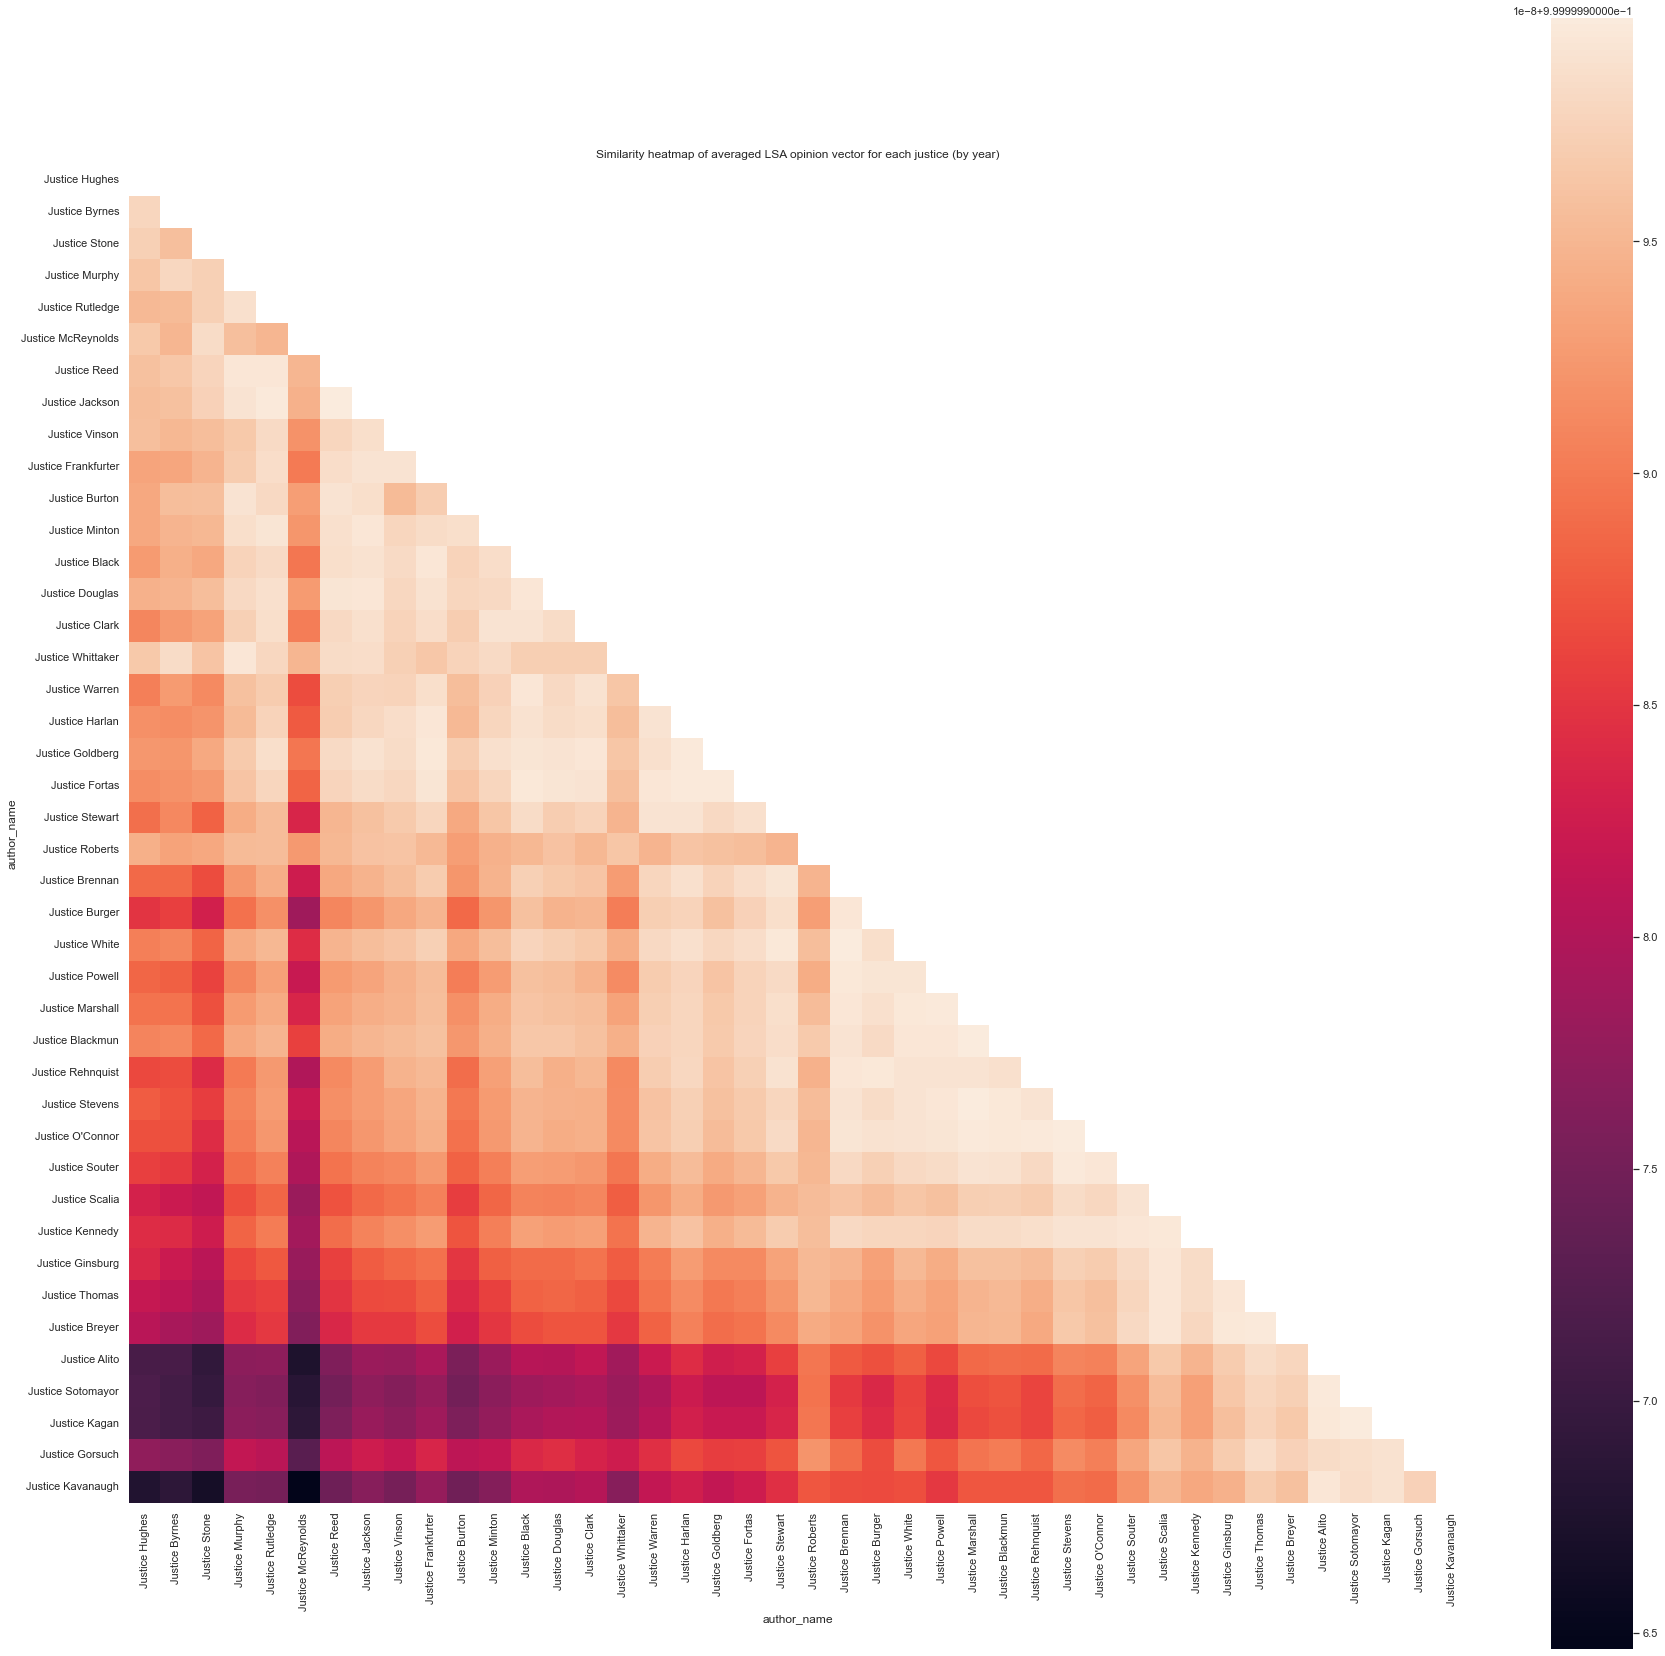

In [35]:
plt.figure(figsize=(30,30))
sns.heatmap(
    lsa_300_df.drop('category', axis=1).groupby('author_name').agg('mean').T.corr().loc[
        temporal_sequence, temporal_sequence
    ],
    square=True,
    mask=mask
)
plt.title("Similarity heatmap of averaged LSA opinion vector for each justice (by year)")
plt.show()

In [36]:
lsa_300_df2 = pd.concat(
    [
        df_40[['author_name','year_filed','case_name', 'category', 'POLITICAL PARTY']].reset_index(drop=True), 
        pd.DataFrame(doc_topic_matrix)
    ],
    axis=1)

lsa_300_df2.head()

,author_name,year_filed,case_name,category,POLITICAL PARTY,0,1,2,3,4,5,6,7,8,9
0,Justice Roberts,2014,McCutcheon v. Federal Election Comm'n,majority,Republican,0.727375,0.000064,0.000064,0.163934,0.000064,0.033766,0.000064,0.000064,0.074541,0.000064
1,Justice Thomas,2014,McCutcheon v. Federal Election Comm'n,concurring,Republican,0.000284,0.000284,0.020106,0.000284,0.000284,0.033119,0.000284,0.000284,0.944786,0.000284
2,Justice Breyer,2014,McCutcheon v. Federal Election Comm'n,dissenting,Democratic,0.009646,0.818430,0.000102,0.086820,0.055720,0.000102,0.000102,0.000102,0.000102,0.028873
3,Justice Kagan,2014,Kaley v. United States,majority,Democratic,0.000368,0.000368,0.000368,0.000368,0.153159,0.000368,0.000368,0.170747,0.673519,0.000368
4,Justice Roberts,2014,Kaley v. United States,dissenting,Republican,0.817430,0.000581,0.000582,0.000581,0.143666,0.000582,0.034833,0.000582,0.000582,0.000581


In [37]:
lda_by_pp = lsa_300_df2[['POLITICAL PARTY'] + list(range(num_topics))].groupby('POLITICAL PARTY').agg('mean')
lda_by_pp.head()

,0,1,2,3,4,5,6,7,8,9
POLITICAL PARTY,,,,,,,,,,
Democratic,0.157971,0.096859,0.083371,0.109015,0.137407,0.029829,0.143676,0.041132,0.127440,0.073300
Republican,0.169508,0.101461,0.088860,0.098527,0.134053,0.026279,0.146256,0.041876,0.114863,0.078317


In [38]:
import numpy as np
df_40['Republican'] = np.where(df_40['POLITICAL PARTY'] == 'Republican', 1, 0)

<AxesSubplot:xlabel='year_filed'>

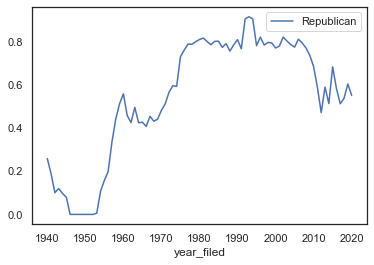

In [39]:
party_plot = df_40[['year_filed', 'Republican']].groupby('year_filed').mean().reset_index()
party_plot.plot(x='year_filed', y='Republican')